#이미지데이터를 사용한 CNN 모델 구축

In [64]:
# 라이브러리 로드
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import cv2
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow

In [3]:
# image 압축파일 다운로드 및 압축해제
fig_zip = 'drive/MyDrive/머신러닝 딥러닝 입문/archive.zip'
# zip파일 압축해제
with zipfile.ZipFile(fig_zip, 'r') as fig_d:
# fig폴더에 압축 해제
    fig_d.extractall('drive/MyDrive/fig')
fig_d.close()

In [5]:
# 폴더(라벨)별 training, validation set 구축
IMG_SIZE = (260, 260)
BATCH_SIZE = 32
fig_dir='drive/MyDrive/fig'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  fig_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE),
  batch_size=BATCH_SIZE)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  fig_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 13344 files belonging to 3 classes.
Using 10676 files for training.
Found 13344 files belonging to 3 classes.
Using 2668 files for validation.


In [6]:
# 클래스 이름 로드
class_names = train_ds.class_names
print(class_names)

['bird', 'cat', 'dog']


In [7]:
# training set의 이미지 파일 및 라벨 shape 확인
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)  
  print(labels_batch.shape)
  break

(32, 260, 260, 3)
(32,)


In [8]:
# 캐싱, 셔플, 프리페치를 통한 이미지 입력 성능향상 진행
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

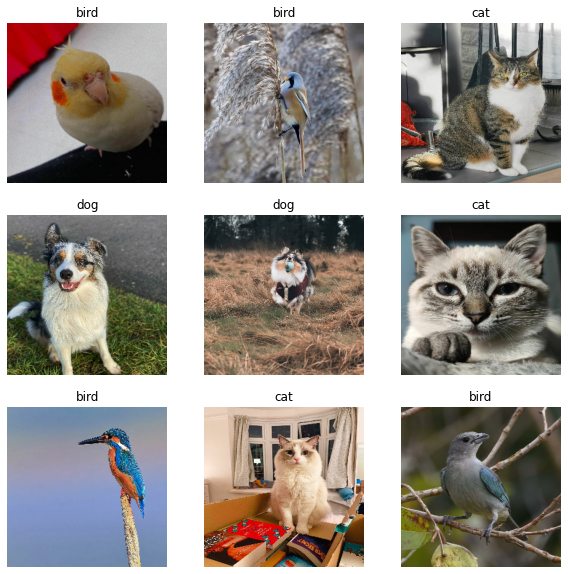

In [9]:
# 라벨, 이미지 확인
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
# label의 클래스 개수 설정
num_classes=3
# CNN 모델 구축 및 표준화
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.8),
  layers.Dense(num_classes, activation='softmax')
])

In [27]:
#CNN 모델 컴파일 및 fit
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])
# 과도학습 방지용 callback 추가
checkpoint_path = '/tmp/checkpoint/models'
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
# train dataset을 널어주면 배치단위로 데이터가 넘어가면서 학습
history = model.fit(
  train_ds,  
  validation_data=validation_ds,
  epochs=20,
  callbacks = [earlystop, checkpoint]
)

Epoch 1/20
334/334 [==============================] - 112s 328ms/step - loss: 1.0955 - accuracy: 0.3908 - val_loss: 1.0842 - val_accuracy: 0.3909
Epoch 2/20
334/334 [==============================] - 112s 329ms/step - loss: 1.0235 - accuracy: 0.4609 - val_loss: 0.9661 - val_accuracy: 0.5154
Epoch 3/20
334/334 [==============================] - 112s 329ms/step - loss: 0.9537 - accuracy: 0.5234 - val_loss: 0.8863 - val_accuracy: 0.5697
Epoch 4/20
334/334 [==============================] - 111s 328ms/step - loss: 0.8839 - accuracy: 0.5761 - val_loss: 0.8355 - val_accuracy: 0.6034
Epoch 5/20
334/334 [==============================] - 110s 324ms/step - loss: 0.8134 - accuracy: 0.6204 - val_loss: 0.8620 - val_accuracy: 0.5708
Epoch 6/20
334/334 [==============================] - 112s 328ms/step - loss: 0.7345 - accuracy: 0.6676 - val_loss: 0.7304 - val_accuracy: 0.6792
Epoch 7/20
334/334 [==============================] - 110s 324ms/step - loss: 0.6868 - accuracy: 0.6974 - val_loss: 0.7322 -

In [28]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 260, 260, 3)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 258, 258, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 129, 129, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 61, 61, 128)      

In [31]:
model.save('/drive/MyDrive/2021266973_Baek keun tae_model.h5')

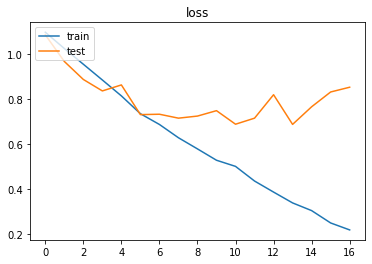

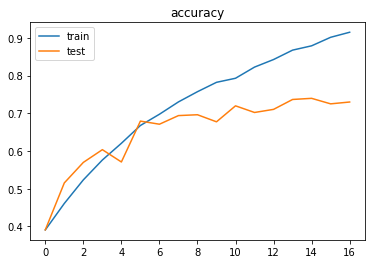

In [29]:
  plt.figure()
  plt.title('loss')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.figure()
  plt.title('accuracy')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train', 'test'], loc='upper left')

In [33]:
model.evaluate(validation_ds)

84/84 [==============================] - 22s 241ms/step - loss: 0.6871 - accuracy: 0.7365


[0.6871376037597656, 0.7365067601203918]

In [44]:
from google.colab import drive
drive.mount('/g')

Mounted at /g


In [71]:
def preprocessing(file, width = 260, height = 260):
  img = cv2.imread(file)
  img = cv2.resize(img, dsize=(width, height))
  cv2_imshow(img)
  imgs = np.expand_dims(img, 0)
  return imgs

def predict_ani(imgs, class_label):
  pred = model.predict(imgs)
  res = np.argmax(pred)
  return class_label[res]

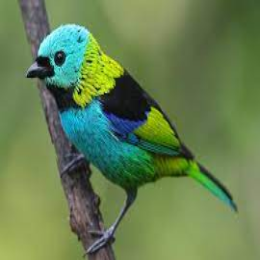

'bird'

In [76]:
file = '/g/My Drive/test/bird_images.jpg'
predict_ani(preprocessing(file), class_names)

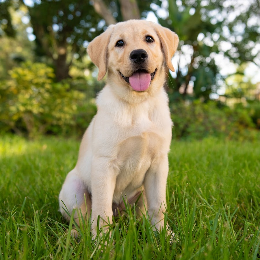

'dog'

In [78]:
file = '/g/My Drive/test/dog_images.jpg'
predict_ani(preprocessing(file), class_names)

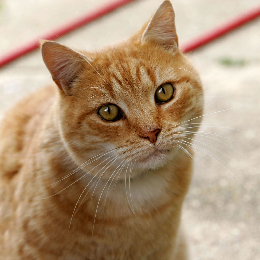

'cat'

In [75]:
file = '/g/My Drive/test/cat_images.jpg'
predict_ani(preprocessing(file), class_names)